In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")


In [302]:
df = pd.read_parquet("df_cleaned.parquet")

In [303]:
# failure data

failure_dates = {
    "A": [
        pd.Timestamp("2025-03-11 23:59:59"),
        pd.Timestamp("2025-09-04 23:59:59")
    ],
    "B": [
        pd.Timestamp("2024-09-17 23:59:59"),
        pd.Timestamp("2024-12-05 23:59:59"),
        pd.Timestamp("2025-05-02 23:59:59")
    ]
}

H = pd.Timedelta("7 days")

df["label"] = 0

for pump, dates in failure_dates.items():
    
    df_p = df[df["pump_id"] == pump]
    
    for d in dates:
        # Find last actual timestamp available before/equal to the failure date
        last_valid = df_p[df_p["timestamp"] <= d]["timestamp"].max()

        # If nothing found (very beginning of dataset)
        if pd.isna(last_valid):
            continue
        
        # Seven-day horizon ends at the last valid sample
        start = last_valid - H
        
        mask = (
            (df["pump_id"] == pump) &
            (df["timestamp"] > start) &
            (df["timestamp"] <= last_valid)
        )
        
        df.loc[mask, "label"] = 1


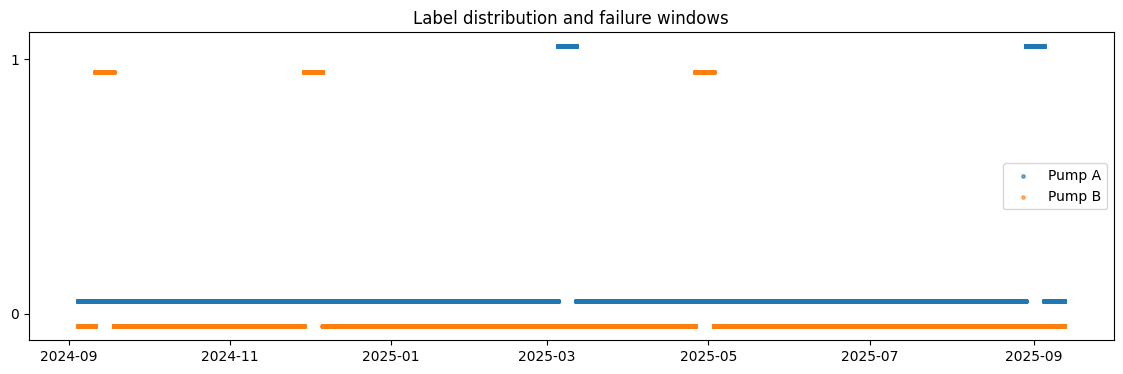

In [304]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,4))

for pump in ['A', 'B']:
    sub = df[df['pump_id']==pump]
    ax.scatter(sub['timestamp'], sub['label'] + (0.05 if pump=='A' else -0.05),
               s=6, label=f'Pump {pump}', alpha=0.6)

ax.set_title("Label distribution and failure windows")
ax.set_yticks([0,1])
ax.legend()
plt.show()


In [305]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['pump_id', 'timestamp'])

In [306]:
df.head()

,timestamp,suction,discharge,output,torque,flow_primary,flow_total,tank_level,drymatter_1,drymatter_2,drymatter_3,productcode_1,productcode_2,productcode_3,pump_id,label
0,2024-09-04 11:30:00,1.499592,3.617833,15.410932,NaN,1.647647,3.123060,2.445410,58.902445,60.530755,58.770573,0.0,1.0,0.0,A,0
2,2024-09-04 11:40:00,1.532229,3.142893,12.059634,NaN,1.082256,2.446991,2.468781,58.917043,60.521769,58.791695,0.0,1.0,0.0,A,0
4,2024-09-04 11:50:00,1.533503,2.884417,10.512563,NaN,0.848890,2.144818,2.471946,58.922533,60.554102,58.790404,0.0,1.0,0.0,A,0
6,2024-09-04 12:00:00,1.500483,3.324420,13.812538,NaN,0.947077,2.805400,2.466533,58.919761,60.613662,58.789230,0.0,1.0,0.0,A,0
8,2024-09-04 12:10:00,1.492766,3.193281,13.196538,NaN,0.748807,2.675767,2.446744,58.919086,60.594212,58.787864,0.0,1.0,0.0,A,0


In [307]:
def build_windows(df, W_days=21, step_minutes=60, min_coverage=0.85):

    W = pd.Timedelta(f"{W_days} days")

    windows = []

    for pump in df["pump_id"].unique():

        df_p = df[df["pump_id"] == pump].sort_values("timestamp").copy()
        df_p = df_p.set_index("timestamp")

        # Only actual timestamps, floored to the hour
        end_times = (
            df_p.index.to_series()
            .dt.floor("h")
            .drop_duplicates()
            .sort_values()
        )
        expected = (24 * 60 // 10) * W_days  # expected 10-min timesteps

        for end_time in end_times:

            start_time = end_time - W

            w = df_p[(df_p.index > start_time) & (df_p.index <= end_time)]

            if len(w) < expected * min_coverage:
                continue

            # label from last row before or equal to end_time
            label = df_p.loc[:end_time]["label"].iloc[-1]

            windows.append({
                "pump_id": pump,
                "start_time": w.index[0],
                "end_time": end_time,
                "label": int(label),
                "window_df": w
            })

    return windows


In [308]:
windows_21 = build_windows(df, 21)

In [309]:


def extract_features_from_window(w):
    df_w = w["window_df"].copy()

    # ------     delta P
    df_w["delta_p"] = df_w["discharge"] - df_w["suction"]
    df_w["active_pressure"] = ((df_w["delta_p"] >= 7.0) &
                               (df_w["delta_p"] <= 8.4)).astype(int)

    #  slope function
    def slope(series):
        s = series.dropna().reset_index(drop=True)
        if len(s) < 2:
            return np.nan
        x = np.arange(len(s))
        m, _ = np.polyfit(x, s, 1)
        return m


    # summary features
    features = {
        "pump_id": w["pump_id"],
        "end_time": w["end_time"],
        "label": w["label"],

        # ΔP
        "delta_p_mean": df_w["delta_p"].mean(),
        "delta_p_std": df_w["delta_p"].std(),
        "delta_p_trend": slope(df_w["delta_p"]),
        "active_pressure_fraction": df_w["active_pressure"].mean(),

        # torque
        "torque_median": df_w["torque"].median(),
        "torque_std": df_w["torque"].std(),
        "torque_trend": slope(df_w["torque"]),

        # output%
        "output_mean": df_w["output"].mean(),
        "output_std": df_w["output"].std(),
        "output_trend": slope(df_w["output"]),

        # Pressure
        "suction_mean": df_w["suction"].mean(),
        "suction_std": df_w["suction"].std(),
        "discharge_mean": df_w["discharge"].mean(),
        "discharge_std": df_w["discharge"].std(),

        # flow
        "flow_primary_mean": df_w["flow_primary"].mean(),
        "flow_total_mean": df_w["flow_total"].mean(),

        # Tank 
        "tank_level_mean": df_w["tank_level"].mean(),
        "tank_level_std": df_w["tank_level"].std(),

        # Dry matter
        "dm1_mean": df_w["drymatter_1"].mean(),
        "dm1_std": df_w["drymatter_1"].std(),
        "dm2_mean": df_w["drymatter_2"].mean(),
        "dm2_std": df_w["drymatter_2"].std(),
        "dm3_mean": df_w["drymatter_3"].mean(),
        "dm3_std": df_w["drymatter_3"].std(),

        # Product codes (fraction of time, when product = 1)
        "pc1_fraction": df_w["productcode_1"].mean(),
        "pc2_fraction": df_w["productcode_2"].mean(),
        "pc3_fraction": df_w["productcode_3"].mean(),
    }

    return features


In [310]:
feature_rows = [extract_features_from_window(w) for w in windows_21]
df_features = pd.DataFrame(feature_rows)

# remove windows with only active_pressure_fraction filled

pump_features = [
    "delta_p_mean", "delta_p_std", "delta_p_trend",
    "output_mean", "output_std", "output_trend",
    "suction_mean", "suction_std",
    "discharge_mean", "discharge_std",
    "flow_primary_mean", "flow_total_mean"
]

# 1: windows must > 0 valid pump features  
mask_nonempty = df_features[pump_features].notna().sum(axis=1) > 0

# 2: windows must have enough valid pump variables
mask_enough_data = df_features[pump_features].notna().sum(axis=1) >= 8

# Final combined 
valid_mask = mask_nonempty & mask_enough_data

df_features_filtered = df_features[valid_mask].reset_index(drop=True)

print("Before filtering:", len(df_features))
print("After filtering:", len(df_features_filtered))
print("Removed windows:", len(df_features) - len(df_features_filtered))


Before filtering: 17056
After filtering: 16712
Removed windows: 344


In [311]:
# end dates of set

true_end_times = {
    "A": pd.Timestamp("2025-09-04 23:59:59"),   # real end of cycle A2
    "B": pd.Timestamp("2025-09-04 23:59:59"),   # same for B (B3 incomplete cycle)
}

# Remove windows that extend beyond 

before = len(df_features_filtered)

df_features_trimmed = df_features_filtered[
    df_features_filtered.apply(
        lambda row: row["end_time"] <= true_end_times[row["pump_id"]],
        axis=1
    )
].reset_index(drop=True)

after = len(df_features_trimmed)

print("Windows before trimming:", before)
print("Windows after trimming:", after)
print("Removed:", before - after)

#  Recompute cycle_id after trimming

cycles = {
    "A": [
        ("A1", "2024-09-04", "2025-03-12"),   # A1 up to day of 1st failure
        ("A2", "2025-03-12", "2025-09-05"),   # A2 ends at true end
    ],
    "B": [
        ("B1", "2024-09-18", "2024-12-06"),
        ("B2", "2024-12-06", "2025-05-03"),
        ("B3", "2025-05-03", "2025-09-05"),   # B3 end fixed at available data
    ]
}

# Convert string dates
for pump in cycles:
    cycles[pump] = [
        (cid, pd.Timestamp(s), pd.Timestamp(e))
        for cid, s, e in cycles[pump]
    ]

df_features_trimmed["cycle_id"] = None

for idx, row in df_features_trimmed.iterrows():
    pump = row["pump_id"]
    t = row["end_time"]

    # assign cycle
    for cid, start, end in cycles[pump]:
        if start <= t < end:
            df_features_trimmed.at[idx, "cycle_id"] = cid
            break



Windows before trimming: 16712
Windows after trimming: 16344
Removed: 368


In [325]:
df_final = df_features_filtered  # after adding cycle_id and trimming windows

In [340]:
import pandas as pd

def assign_cycle_id(df, cycles):
    df["cycle_id"] = None
    
    for pump, cycles in cycles.items():
        for cycle_name, start, end in cycles:
            start = pd.Timestamp(start)
            end   = pd.Timestamp(end)

            mask = (
                (df["pump_id"] == pump) &
                (df["end_time"] >= start) &
                (df["end_time"] <  end)
            )
            df.loc[mask, "cycle_id"] = cycle_name
    
    return df

df_final = assign_cycle_id(df_final, cycles)
df_final = df_final[df_final["cycle_id"].notna()].reset_index(drop=True)





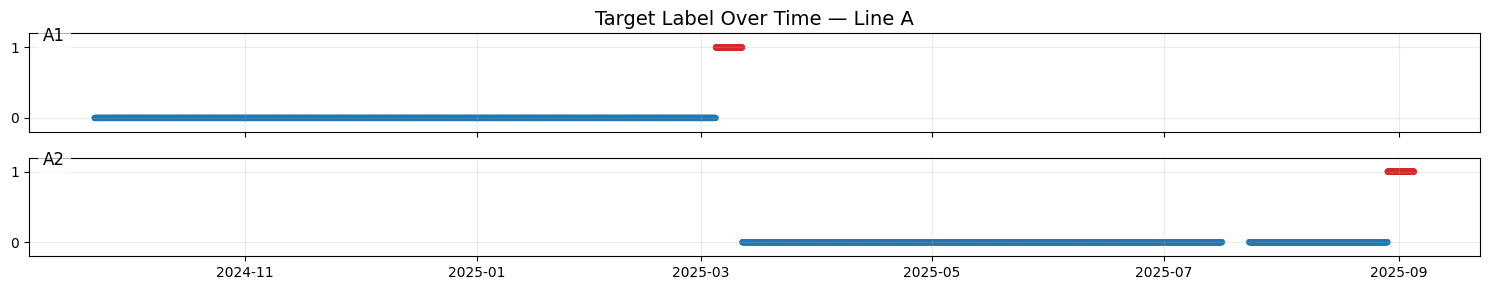

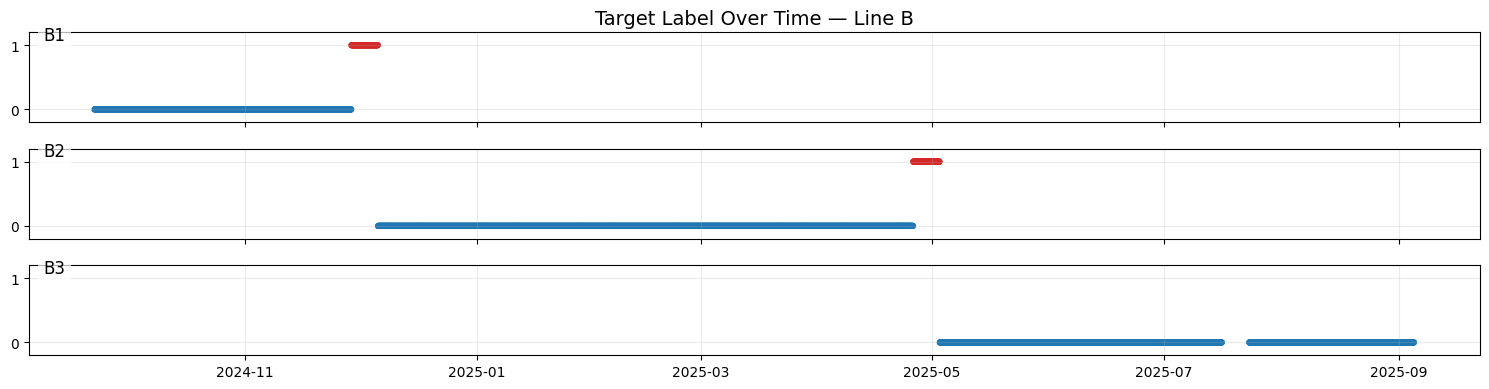

In [355]:


# --- Settings 
cycles_A = ["A1", "A2"]
cycles_B = ["B1", "B2", "B3"]

color_map = {0: "tab:blue", 1: "tab:red"}

# -fig 1 -= a cycles
fig, axes = plt.subplots(len(cycles_A), 1, figsize=(15, 3), sharex=True)

for ax, cid in zip(axes, cycles_A):

    sub = df_final[df_final["cycle_id"] == cid]

    ax.scatter(
        sub["end_time"],
        sub["label"],
        s=12,
        c=sub["label"].map(color_map),
        alpha=0.7,
    )

    # Add cycle label above line
    ax.text(
        0.01, 0.92,
        cid,
        transform=ax.transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

    ax.set_yticks([0, 1])
    ax.set_ylim(-0.2, 1.2)
    ax.grid(True, alpha=0.25)

axes[0].set_title("Target Label Over Time — Line A", fontsize=14)
plt.tight_layout()
plt.show()


# fig 2 - b cycles
fig, axes = plt.subplots(len(cycles_B), 1, figsize=(15, 4), sharex=True)

for ax, cid in zip(axes, cycles_B):

    sub = df_final[df_final # Save to Parquet
df_long_10m.to_parquet("df_cleaned.parquet", index=False)["cycle_id"] == cid]

    ax.scatter(
        sub["end_time"],
        sub["label"],
        s=12,
        c=sub["label"].map(color_map),
        alpha=0.7,
    )

    ax.text(
        0.01, 0.92,
        cid,
        transform=ax.transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

    ax.set_yticks([0, 1])
    ax.set_ylim(-0.2, 1.2)
    ax.grid(True, alpha=0.25)

axes[0].set_title("Target Label Over Time — Line B", fontsize=14)
plt.tight_layout()
plt.show()


In [358]:
# Save to Parquet
df_final.to_parquet("df_preprocessed.parquet", index=False)